In [44]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/home/redhog/Projects/innovationgarage/DrowningWarning-analytics/env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [45]:
import sklearn.decomposition
import scipy.signal

In [46]:
merged=pd.read_csv("../data/merged/capture_246058.txt", delimiter=",", parse_dates=['timestamp'])

In [47]:
data=pd.read_csv("../data/clean/capture.capture_246058.txt", delimiter=",", parse_dates=['timestamp'])

In [48]:
len(data) / (data["timestamp"].max() - data["timestamp"].min()).total_seconds()

11.670923661082549

In [49]:
starttime = data["timestamp"].min()
endtime = data["timestamp"].max()

In [50]:
data.set_index('timestamp', inplace=True)
data = data.resample("0.1S").mean()

In [51]:
data = data.interpolate() 

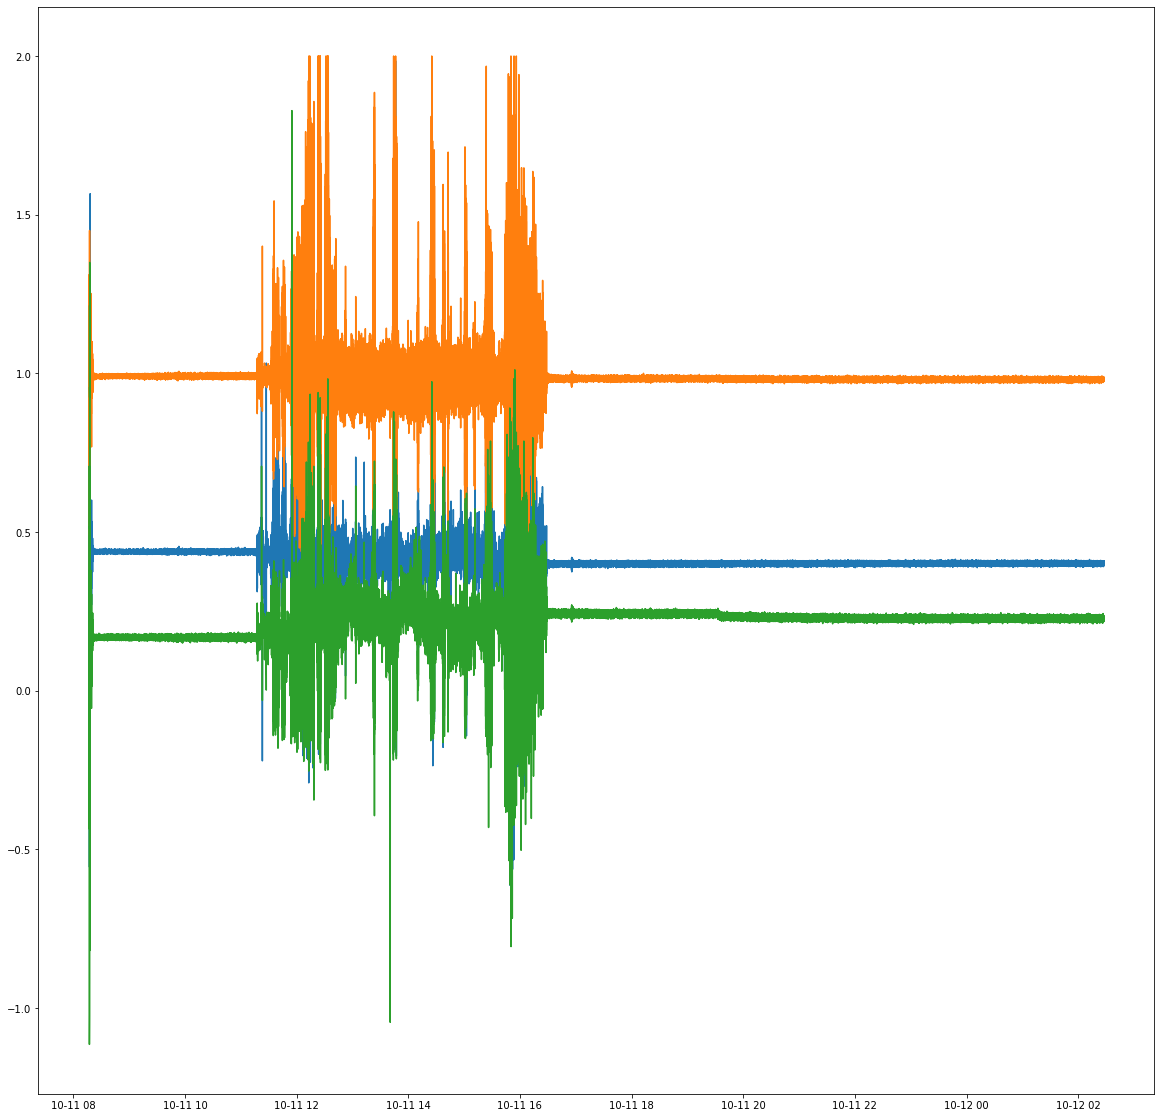

In [52]:
plt.figure(figsize=(20, 20))
plt.plot(data["ax"])
plt.plot(data["ay"])
plt.plot(data["az"])


In [53]:
p = sklearn.decomposition.PCA(1)
d = p.fit_transform(data[["ax", "ay", "az"]].values)

In [178]:
M=400
f, t, Sxx = scipy.signal.spectrogram(
    d[:,0],
    window=scipy.signal.windows.kaiser(M, 5),
    nperseg=M, noverlap=M/2, fs=10)

t = np.array(starttime, dtype="datetime64") + t.astype("timedelta64[s]")

/home/redhog/Projects/innovationgarage/DrowningWarning-analytics/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  import sys


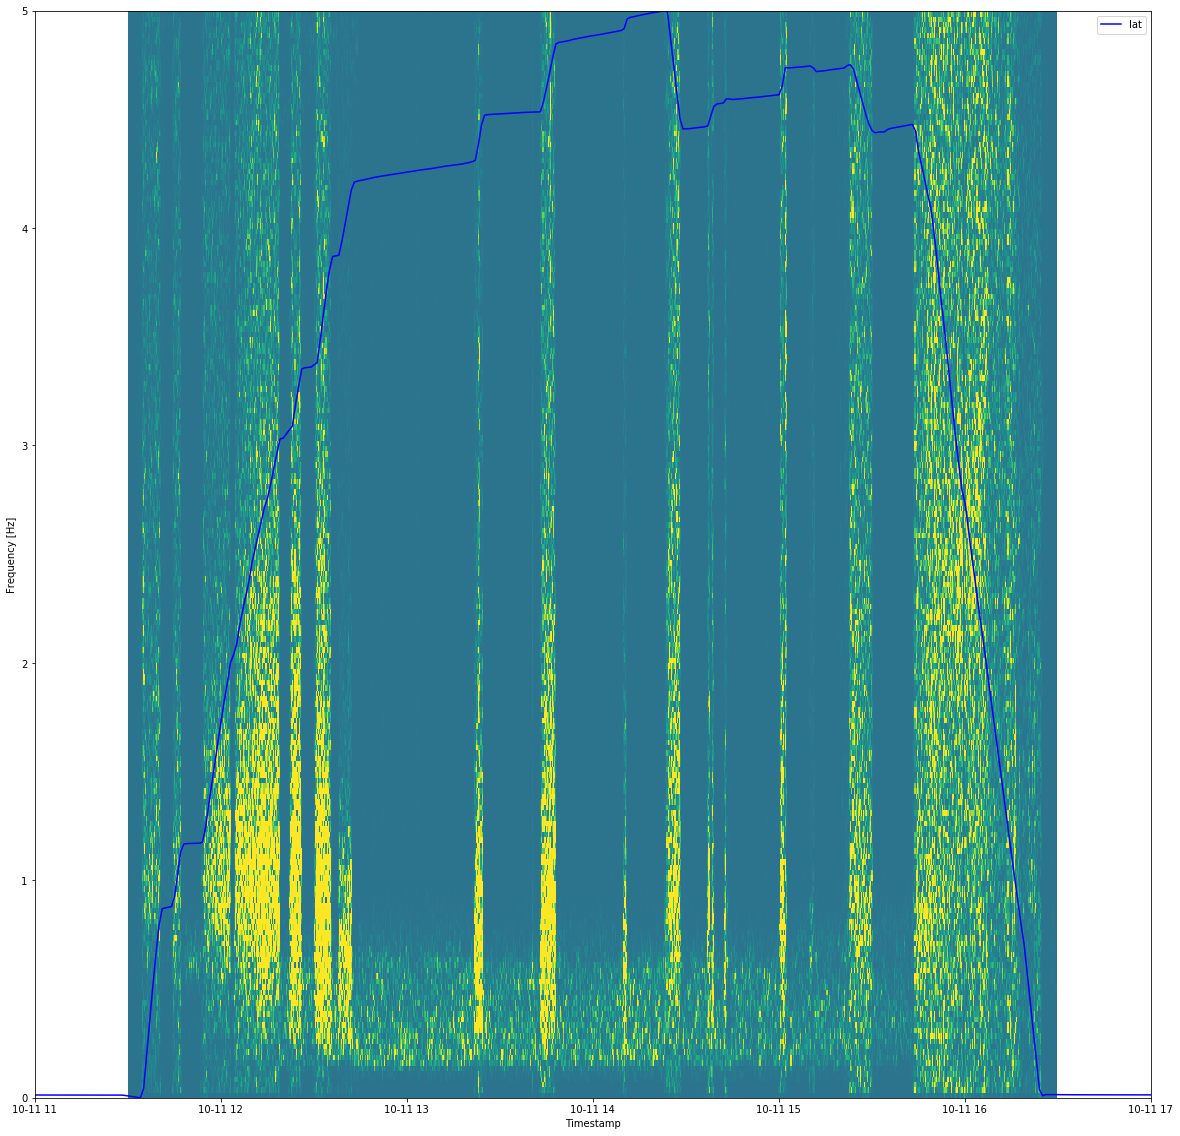

In [179]:
w = np.where((t > datetime.datetime(2019, 10, 11, 11, 30)) & (t < datetime.datetime(2019, 10, 11, 16, 30)))[0]
tt = t[w]
ss = Sxx[:,w]
dd = d[::M//2,0][:-2]
dd = dd[w]
dd = dd - dd.min()
dd = dd / dd.max() * f.max()

plt.figure(figsize=(20, 20))
plt.pcolormesh(tt, f, ss, vmin=ss.mean() - ss.std(), vmax=ss.mean() + ss.std())

lats = merged.lat.values - merged.lat.values.min()
lats = f.max() * lats / lats.max()
plt.plot(merged.timestamp.values, lats, color="blue", label="lat")

plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestamp')
plt.legend()
plt.show()


In [139]:
pdSxx = pd.DataFrame(Sxx.transpose(), index=t, columns=f)
pdSxx["timestamp"] = pdSxx.index

speeds = merged[["timestamp", "speed_knots"]]
speeds = speeds.set_index("timestamp")
speeds = speeds.tz_localize(None)

speedgraph = pd.merge(pdSxx, speeds, how='left', on='timestamp', sort=True)
speedgraph = speedgraph.set_index("timestamp")
speedgraph = speedgraph.interpolate()

speedgraph = speedgraph.dropna()
speedgraph = speedgraph.set_index("speed_knots").sort_index()

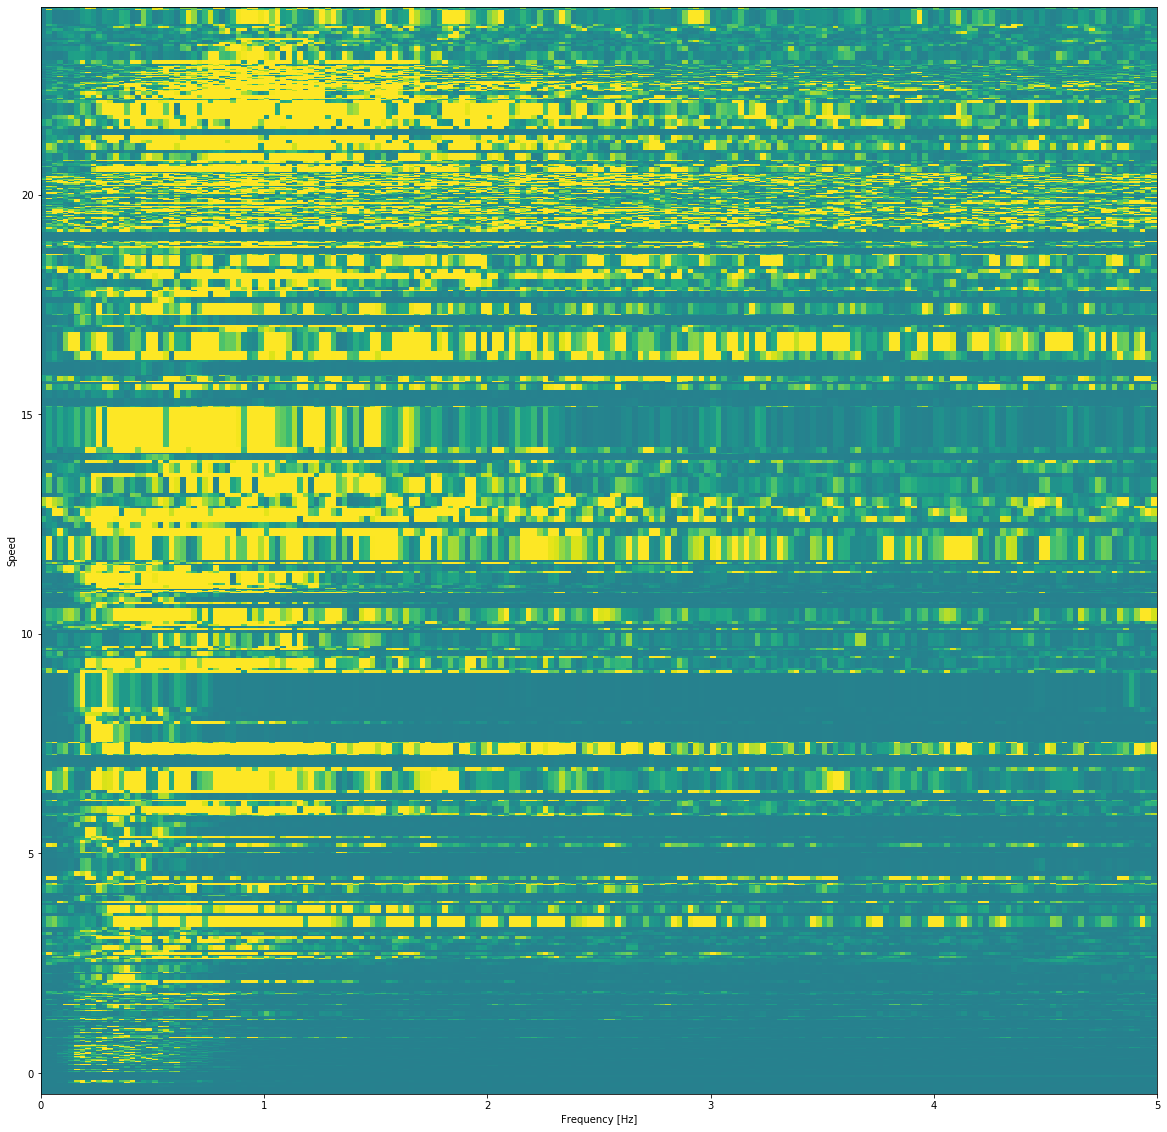

In [177]:
plt.figure(figsize=(20, 20))
v = speedgraph.values
plt.pcolormesh(speedgraph.columns, speedgraph.index, v, vmin=v.mean()-v.std(), vmax=v.mean()+v.std())
plt.ylabel('Speed')
plt.xlabel('Frequency [Hz]')
plt.show()


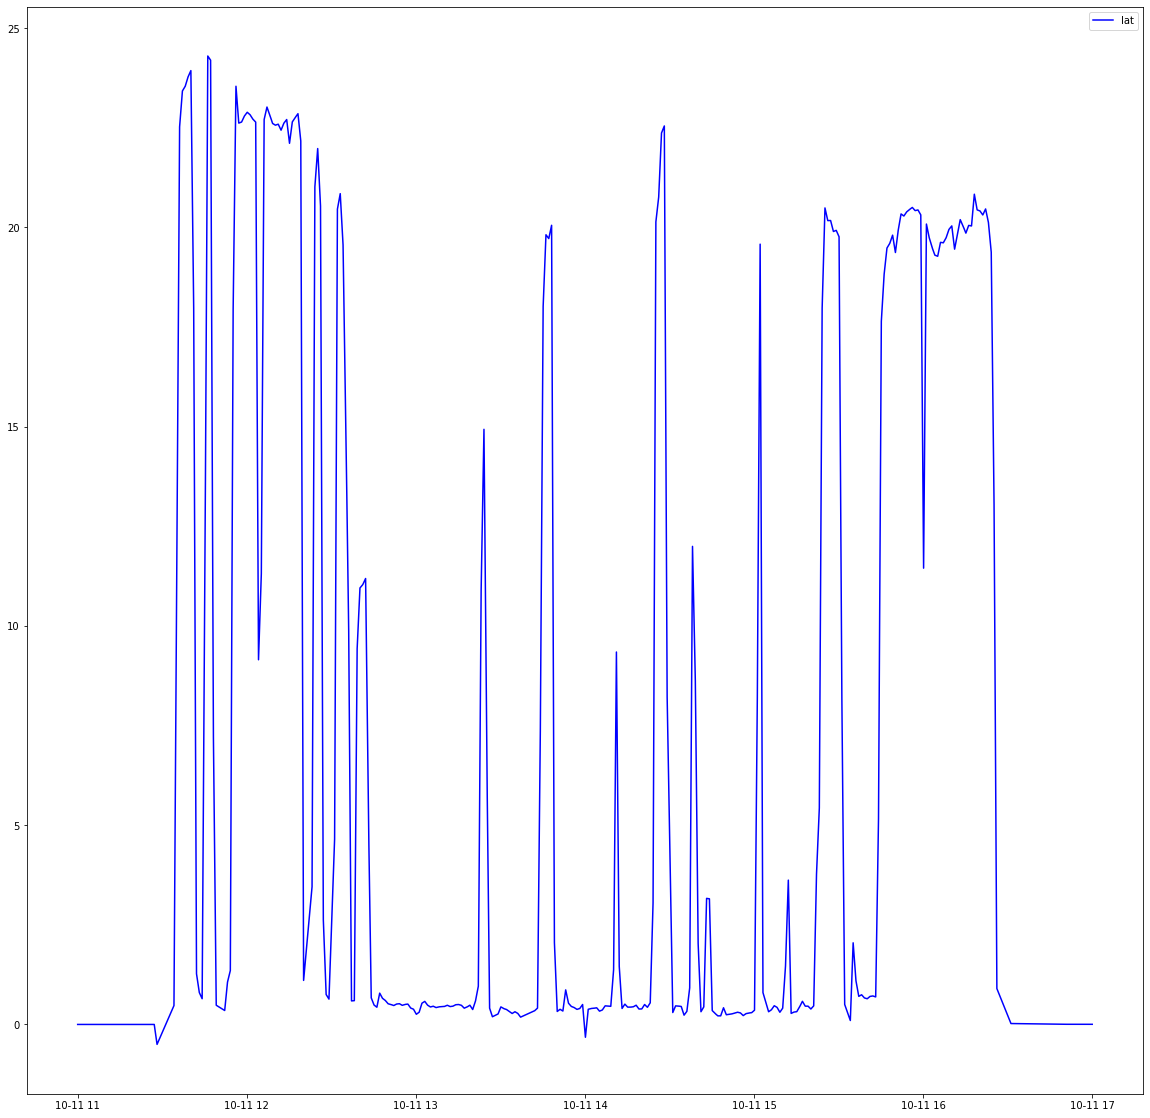

In [180]:
plt.figure(figsize=(20, 20))

plt.plot(merged.timestamp.values, merged.speed_knots.values, color="blue", label="lat")
plt.legend()
plt.show()